In [875]:
import numpy as np
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T

In [876]:
train_size = 540
val_size = 60
total = 600

In [877]:
def load_dataset():
    train_dataset = h5py.File("happy-house-dataset/train_happy.h5",'r+')
    test_dataset = h5py.File("happy-house-dataset/test_happy.h5",'r+')

#     trD = np.array(train_dataset["train_set_x"][0:train_size])
#     trY = np.array(train_dataset["train_set_y"][0:train_size])
    trD = np.array(train_dataset["train_set_x"][:])
    trY = np.array(train_dataset["train_set_y"][:])
    
    valD = np.array(train_dataset["train_set_x"][train_size:total])
    valY = np.array(train_dataset["train_set_y"][train_size:total])

    tstD = np.array(test_dataset["test_set_x"][:])
    tstY = np.array(test_dataset["test_set_y"][:])
    
    return trD, trY, valD, valY, tstD, tstY


In [878]:
trD, trY, valD, valY, tstD, tstY = load_dataset()

print(trD.shape)
print(trY.shape)

print(valD.shape)
print(valY.shape)

print(tstY.shape)
print(tstD.shape)

(600, 64, 64, 3)
(600,)
(60, 64, 64, 3)
(60,)
(150,)
(150, 64, 64, 3)


In [895]:
class HappyDataset(Dataset):
    """Happy dataset."""

    def __init__(self, trD, trY, transform=None):
        """
        Args:
            images(list): images list.
            labels(list): labels if images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.trD = trD
        self.transform = transform
        self.length=trD.shape[0]
        self.labels=trY
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = self.trD[idx]
        if self.transform:
            image = self.transform(image)
        sample={'image':image,'Label':self.labels[idx], 'idx':idx}
        return sample

In [896]:
image_dataset = HappyDataset(trD, trY, transform=T.ToTensor())

#iterating though the dataset
for i in range(5):
    sample=image_dataset[i]
    print(sample['image'].shape)
    print(sample['Label'])
    print(sample['idx'])

torch.Size([3, 64, 64])
0
0
torch.Size([3, 64, 64])
1
1
torch.Size([3, 64, 64])
1
2
torch.Size([3, 64, 64])
1
3
torch.Size([3, 64, 64])
1
4


In [897]:
image_dataloader = DataLoader(image_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i,sample in enumerate(image_dataloader):
    sample['image']=sample['image']
    print(sample['idx'],sample['image'].shape, sample['Label'])
    if i>5: 
        break

(tensor([287, 366, 365, 599]), torch.Size([4, 3, 64, 64]), tensor([1, 1, 0, 0]))
(tensor([580, 192, 144, 593]), torch.Size([4, 3, 64, 64]), tensor([0, 0, 1, 1]))
(tensor([294, 527,  62, 578]), torch.Size([4, 3, 64, 64]), tensor([0, 0, 0, 1]))
(tensor([422, 544, 269, 179]), torch.Size([4, 3, 64, 64]), tensor([1, 0, 0, 0]))
(tensor([180, 562, 513,  70]), torch.Size([4, 3, 64, 64]), tensor([0, 1, 0, 1]))
(tensor([ 92, 559, 355,  63]), torch.Size([4, 3, 64, 64]), tensor([0, 0, 1, 1]))
(tensor([199,  22, 357, 107]), torch.Size([4, 3, 64, 64]), tensor([0, 1, 0, 0]))


In [898]:
my_batch_size = 15

data_transforms = T.Compose([
        T.ToPILImage(),
        T.RandomHorizontalFlip(),
        T.ToTensor()])


# image_dataset_train = HappyDataset(trD, trY, transform=T.ToTensor())
image_dataset_train = HappyDataset(trD, trY, transform=data_transforms)
image_dataloader_train = DataLoader(image_dataset_train, batch_size=my_batch_size,
                        shuffle=True, num_workers=4)

image_dataset_val = HappyDataset(valD, valY, transform=T.ToTensor())
image_dataloader_val = DataLoader(image_dataset_val, batch_size=my_batch_size,
                        shuffle=True, num_workers=4)

image_dataset_test = HappyDataset(tstD, tstY, transform=T.ToTensor())
image_dataloader_test = DataLoader(image_dataset_test, batch_size=my_batch_size,
                        shuffle=True, num_workers=4)


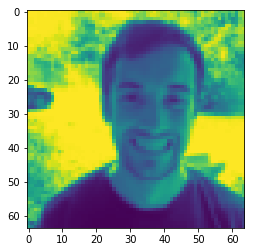

smile


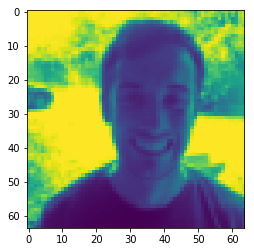

smile


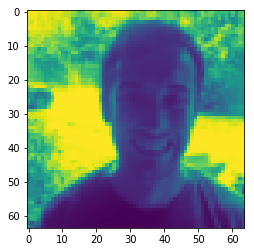

smile


In [899]:
import matplotlib.pyplot as plt
import torchvision

classes = ('no-smile', 'smile')
# functions to show an image

def imshow(img):
    plt.imshow(img)
    plt.show()

for i,sample in enumerate(image_dataloader_train):
    sample['image']=sample['image']
    for img in sample['image'][0]:
        imshow(img)
        print(classes[sample['Label'][0]])
    break
    



In [900]:
dtype = torch.FloatTensor # the CPU datatype
# Constant to control how frequently we print train loss
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [901]:
from tqdm import tqdm

def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in tqdm(range(num_epochs)):
#         print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [902]:

def init_model():
    gpu_dtype = torch.cuda.FloatTensor

    first_layer = 128
    second_layer = 256
    third_layer = 64

    # first_layer = 256
    # second_layer = 512
    # third_layer = 64

    # Here's where we define the architecture of the model... 
    # model 3*64*64
    # 3 clips of same person and labels
    model = nn.Sequential(
                    nn.Conv2d(3, first_layer, kernel_size=3, stride=1), #62
                    nn.BatchNorm2d(first_layer),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(kernel_size=2, stride=2), #31

                    nn.Conv2d(first_layer, second_layer, kernel_size=2, stride=1), #28
                    nn.BatchNorm2d(second_layer),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(0.25),
                    nn.MaxPool2d(kernel_size=2, stride=2), #14

                    nn.Conv2d(second_layer, third_layer, kernel_size=3, stride=1), #11
                    nn.BatchNorm2d(third_layer),
                    nn.ReLU(inplace=True),
                    nn.Dropout2d(0.4),
                    nn.MaxPool2d(kernel_size=2, stride=2), #6*6*64 = 2306/36 * 36

                    Flatten(),
                    nn.ReLU(inplace=True),
                    nn.Linear(6*6*third_layer, 256),
                    nn.Linear(256, 2),
                    nn.Softmax()
                  )

    # Set the type of all data in this model to be FloatTensor 
    model.type(gpu_dtype)
    model.cuda()
    return model

model = init_model()

In [903]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(my_batch_size, 3, 64, 64).type(gpu_dtype)
x_var = Variable(x.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
print(np.array(ans.size()))
np.array_equal(np.array(ans.size()), np.array([my_batch_size, 2]))

[15  2]


True

In [904]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-3)


In [905]:
print_every = 100
train(model, loss_fn, optimizer, image_dataloader_train, num_epochs=35)

100%|██████████| 35/35 [00:17<00:00,  2.08it/s]


In [906]:
check_accuracy(model, image_dataloader_train)# check accuracy on the training set
check_accuracy(model, image_dataloader_val)# check accuracy on the training set

Got 599 / 600 correct (99.83)
Got 60 / 60 correct (100.00)


1.0

In [907]:
check_accuracy(model, image_dataloader_test)# check accuracy on the training set

Got 147 / 150 correct (98.00)


0.98